In [ ]:
! pip install surprise

In [1]:
# referenced # https://www.kaggle.com/code/kefahaied/netflix-movie-recommendation-kefah

# To store the data
import pandas as pd

# To do linear algebra
import numpy as np

# To create plots
import matplotlib.pyplot as plt
import seaborn as sns
# To create interactive plots
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

# To shift lists
from collections import deque

# To compute similarities between vectors
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# To use recommender systems
# import surprise as sp
# from surprise.model_selection import cross_validate

# To create deep learning models
from keras.layers import Input, Embedding, Reshape, Dot, Concatenate, Dense, Dropout
from keras.models import Model

In [2]:
nRowsRead = 1000 # specify 'None' if want to read whole file
# movie_titles.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df_movies = pd.read_csv('movie_titles.csv', index_col=0, names=['year','title'], nrows = nRowsRead, on_bad_lines='skip')
df_movies.dataframeName = 'movie_titles.csv'
nRow, nCol = df_movies.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 2 columns


In [3]:
df_movies.head()

,year,title
1,2003,Dinosaur Planet
2,2004,Isle of Man TT 2004 Review
3,1997,Character
4,1994,Paula Abdul's Get Up & Dance
5,2004,The Rise and Fall of ECW


In [4]:
df_raw = pd.read_csv('combined_data_1.txt', header=None, names=['user_id','rating','date'], usecols=[0,1,2])
df_raw.head()

,user_id,rating,date
0,1:,NaN,NaN
1,1488844,3.0,2005-09-06
2,822109,5.0,2005-05-13
3,885013,4.0,2005-10-19
4,30878,4.0,2005-12-26


In [5]:
movie_indx_df = df_raw[df_raw['rating'].isna()]['user_id'].reset_index()
movie_indx_df.head()

,index,user_id
0,0,1:
1,548,2:
2,694,3:
3,2707,4:
4,2850,5:


In [6]:
movie_indx_df.values

array([[0, '1:'],
       [548, '2:'],
       [694, '3:'],
       ...,
       [24056849, '4497:'],
       [24057564, '4498:'],
       [24057834, '4499:']], dtype=object)

In [7]:
movie_indx = [[index, int(movie[:-1])] for index, movie in movie_indx_df.values]
movie_indx

[[0, 1],
 [548, 2],
 [694, 3],
 [2707, 4],
 [2850, 5],
 [3991, 6],
 [5011, 7],
 [5105, 8],
 [20016, 9],
 [20112, 10],
 [20362, 11],
 [20561, 12],
 [21108, 13],
 [21234, 14],
 [21353, 15],
 [21644, 16],
 [24344, 17],
 [31453, 18],
 [42176, 19],
 [42716, 20],
 [42833, 21],
 [43052, 22],
 [43256, 23],
 [43872, 24],
 [45206, 25],
 [46414, 26],
 [52276, 27],
 [52550, 28],
 [92303, 29],
 [92827, 30],
 [211241, 31],
 [211463, 32],
 [213318, 33],
 [220209, 34],
 [220318, 35],
 [221158, 36],
 [222098, 37],
 [222380, 38],
 [223183, 39],
 [223936, 40],
 [224428, 41],
 [224522, 42],
 [224651, 43],
 [224757, 44],
 [233259, 45],
 [235879, 46],
 [242438, 47],
 [244789, 48],
 [248381, 49],
 [248613, 50],
 [248942, 51],
 [249033, 52],
 [254181, 53],
 [254296, 54],
 [254456, 55],
 [256863, 56],
 [258697, 57],
 [262260, 58],
 [279666, 59],
 [279871, 60],
 [280167, 61],
 [280315, 62],
 [280606, 63],
 [280791, 64],
 [280887, 65],
 [281146, 66],
 [281313, 67],
 [281603, 68],
 [283820, 69],
 [283937, 70],
 [

In [8]:
# Shift the movie_indices by one to get start and endpoints of all movies
shifted_movie_indices = deque(movie_indx)
shifted_movie_indices.rotate(-1) # rotate right to left
shifted_movie_indices

deque([[548, 2],
       [694, 3],
       [2707, 4],
       [2850, 5],
       [3991, 6],
       [5011, 7],
       [5105, 8],
       [20016, 9],
       [20112, 10],
       [20362, 11],
       [20561, 12],
       [21108, 13],
       [21234, 14],
       [21353, 15],
       [21644, 16],
       [24344, 17],
       [31453, 18],
       [42176, 19],
       [42716, 20],
       [42833, 21],
       [43052, 22],
       [43256, 23],
       [43872, 24],
       [45206, 25],
       [46414, 26],
       [52276, 27],
       [52550, 28],
       [92303, 29],
       [92827, 30],
       [211241, 31],
       [211463, 32],
       [213318, 33],
       [220209, 34],
       [220318, 35],
       [221158, 36],
       [222098, 37],
       [222380, 38],
       [223183, 39],
       [223936, 40],
       [224428, 41],
       [224522, 42],
       [224651, 43],
       [224757, 44],
       [233259, 45],
       [235879, 46],
       [242438, 47],
       [244789, 48],
       [248381, 49],
       [248613, 50],
       [248942, 5

In [9]:
list(zip(movie_indx, shifted_movie_indices))

[([0, 1], [548, 2]),
 ([548, 2], [694, 3]),
 ([694, 3], [2707, 4]),
 ([2707, 4], [2850, 5]),
 ([2850, 5], [3991, 6]),
 ([3991, 6], [5011, 7]),
 ([5011, 7], [5105, 8]),
 ([5105, 8], [20016, 9]),
 ([20016, 9], [20112, 10]),
 ([20112, 10], [20362, 11]),
 ([20362, 11], [20561, 12]),
 ([20561, 12], [21108, 13]),
 ([21108, 13], [21234, 14]),
 ([21234, 14], [21353, 15]),
 ([21353, 15], [21644, 16]),
 ([21644, 16], [24344, 17]),
 ([24344, 17], [31453, 18]),
 ([31453, 18], [42176, 19]),
 ([42176, 19], [42716, 20]),
 ([42716, 20], [42833, 21]),
 ([42833, 21], [43052, 22]),
 ([43052, 22], [43256, 23]),
 ([43256, 23], [43872, 24]),
 ([43872, 24], [45206, 25]),
 ([45206, 25], [46414, 26]),
 ([46414, 26], [52276, 27]),
 ([52276, 27], [52550, 28]),
 ([52550, 28], [92303, 29]),
 ([92303, 29], [92827, 30]),
 ([92827, 30], [211241, 31]),
 ([211241, 31], [211463, 32]),
 ([211463, 32], [213318, 33]),
 ([213318, 33], [220209, 34]),
 ([220209, 34], [220318, 35]),
 ([220318, 35], [221158, 36]),
 ([221158, 36

In [10]:
# Gather all dataframes
user_data = []

# Iterate over all movies
for [df_id_1, movid_id], [df_id_2, next_movie_id] in zip(movie_indx, shifted_movie_indices):

    # Check if it is the last movie in the file:
    if df_id_1 < df_id_2:
        tmp_df = df_raw.loc[df_id_1+1:df_id_2-1].copy()
    else:
        tmp_df = df_raw.loc[df_id_1+1:].copy()

    # Create movie_id column
    tmp_df['movie_id'] = movid_id

    # Append dataframe to list
    user_data.append(tmp_df)

user_data

[     user_id  rating        date  movie_id
 1    1488844     3.0  2005-09-06         1
 2     822109     5.0  2005-05-13         1
 3     885013     4.0  2005-10-19         1
 4      30878     4.0  2005-12-26         1
 5     823519     3.0  2004-05-03         1
 ..       ...     ...         ...       ...
 543  1790158     4.0  2005-05-17         1
 544  1403184     3.0  2005-11-12         1
 545  1535440     4.0  2005-08-18         1
 546  1426604     4.0  2005-09-01         1
 547  1815755     5.0  2004-07-20         1
 
 [547 rows x 4 columns],
      user_id  rating        date  movie_id
 549  2059652     4.0  2005-09-05         2
 550  1666394     3.0  2005-04-19         2
 551  1759415     4.0  2005-04-22         2
 552  1959936     5.0  2005-11-21         2
 553   998862     4.0  2004-11-13         2
 ..       ...     ...         ...       ...
 689  1581265     3.0  2005-04-15         2
 690   515436     1.0  2005-02-13         2
 691  1824543     4.0  2005-04-20         2
 692 

In [23]:
# combine all dataframes

df = pd.concat(user_data)
df.head()

,user_id,rating,date,movie_id
1,1488844,3.0,2005-09-06,1
2,822109,5.0,2005-05-13,1
3,885013,4.0,2005-10-19,1
4,30878,4.0,2005-12-26,1
5,823519,3.0,2004-05-03,1


In [24]:
df.shape

(24053764, 4)

In [25]:
df = df.sample(n=100000, random_state=123)

In [26]:
ratings_mean_count = pd.DataFrame(df.groupby('movie_id')['rating'].mean())
ratings_mean_count

,rating
movie_id,
3,3.666667
5,4.500000
6,2.500000
8,3.049180
10,3.000000
...,...
4495,3.200000
4496,3.823529
4497,3.000000


In [27]:
ratings_mean_count['rating_counts'] = pd.DataFrame(df.groupby('movie_id')['rating'].count())
ratings_mean_count

,rating,rating_counts
movie_id,,
3,3.666667,9
5,4.500000,6
6,2.500000,8
8,3.049180,61
10,3.000000,3
...,...,...
4495,3.200000,5
4496,3.823529,34
4497,3.000000,2


<AxesSubplot: >

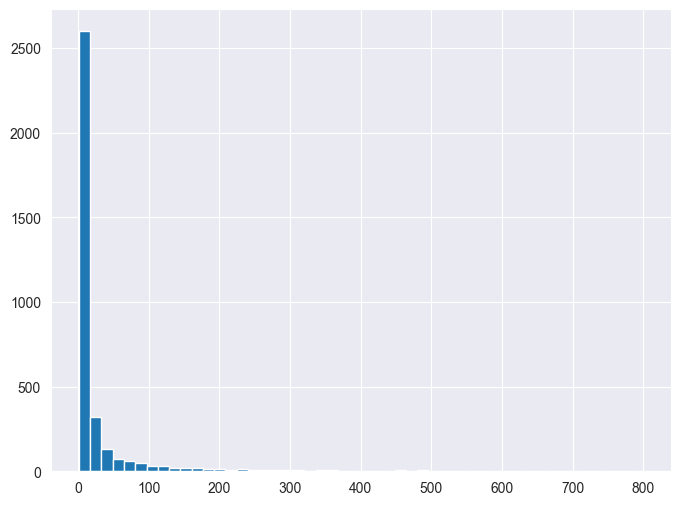

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')
%matplotlib inline

plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=50)

<AxesSubplot: >

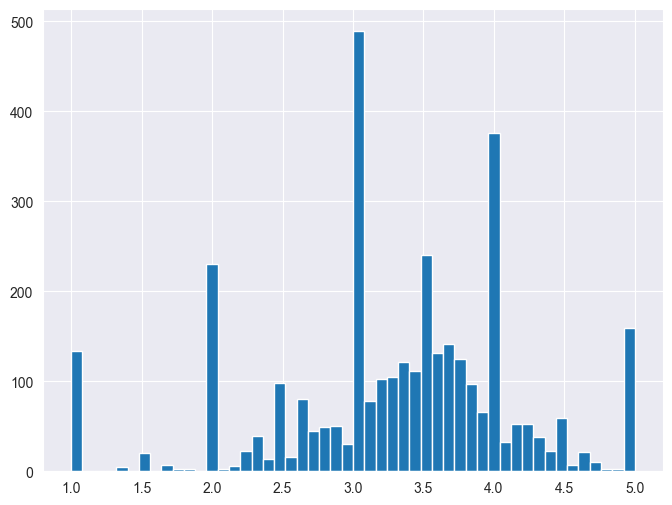

In [29]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating'].hist(bins=50)

<Figure size 800x600 with 0 Axes>

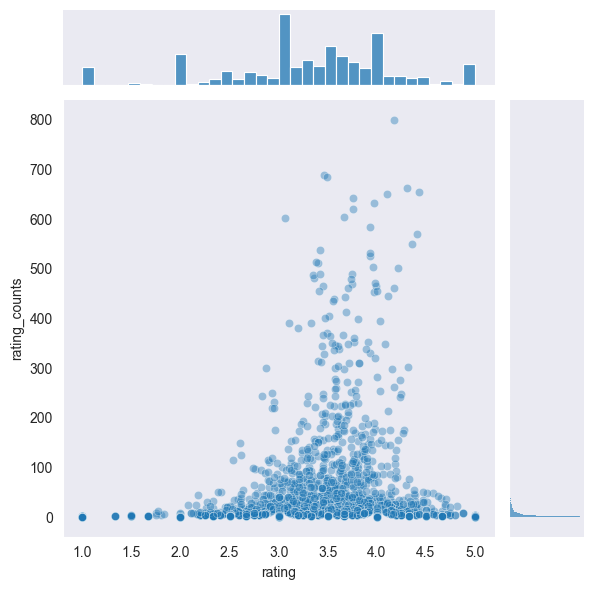

In [30]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)

In [31]:
df.head()

,user_id,rating,date,movie_id
15098449,1511139,3.0,2005-04-22,2908
18515401,2495968,5.0,2004-12-20,3538
7360242,1152721,4.0,2005-11-17,1470
9304402,2207042,3.0,2002-05-04,1834
10741767,590757,4.0,2004-09-19,2112


In [32]:
user_movie_rating = df.pivot_table(index='user_id', columns='movie_id', values='rating')

In [33]:
user_movie_rating.head()

movie_id,3,5,6,8,10,12,16,17,18,19,...,4490,4491,4492,4493,4494,4495,4496,4497,4498,4499
user_id,,,,,,,,,,,,,,,,,,,,,
1000062,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000287,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
movie_8_ratings = user_movie_rating[8]
movie_8_ratings.head()

user_id
1000062   NaN
1000192   NaN
1000234   NaN
1000278   NaN
1000287   NaN
Name: 8, dtype: float64

In [49]:
movie_8_ratings.count()

61

In [53]:
user_movie_rating.corrwith(movie_8_ratings).count()

C:\Users\User\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:518: RuntimeWarning:

Mean of empty slice.

C:\Users\User\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:182: RuntimeWarning:

invalid value encountered in divide

C:\Users\User\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\User\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning:

divide by zero encountered in divide

C:\Users\User\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning:

invalid value encountered in multiply



1

In [51]:
movies_like_movie_8 = user_movie_rating.corrwith(movie_8_ratings)

corr_movie_8 = pd.DataFrame(movies_like_movie_8, columns=['Correlation'])
corr_movie_8.dropna(inplace=True)
corr_movie_8

C:\Users\User\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:518: RuntimeWarning:

Mean of empty slice.

C:\Users\User\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:182: RuntimeWarning:

invalid value encountered in divide

C:\Users\User\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\User\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning:

divide by zero encountered in divide

C:\Users\User\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning:

invalid value encountered in multiply



,Correlation
8,1.0
